In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import show_img, loss_plots, accuracy_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
val = True
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
# dataset = OwnDataset(transform=tf)
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)




train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=True, pin_memory=cuda)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 4884 1527 1221


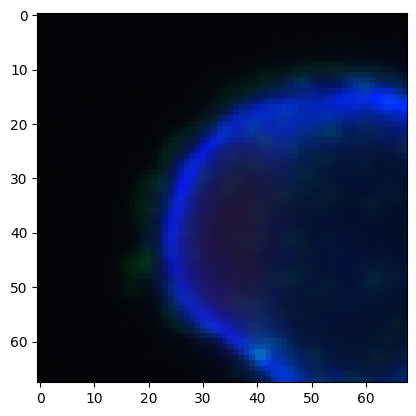

'Actin disruptors'

In [3]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


In [4]:
from models import LatentClassifier, VAE_CELL_CNN

# load pre-trained model
vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
vae.load_state_dict(torch.load(r"VAE_own_CNN_best_model.pth"))
vae.eval()
latent_classifier = LatentClassifier(latent_dim=256, hidden_dim=128, num_classes=len(dataset.dataset.classes))
print(vae)
print(latent_classifier)

if cuda:
    vae = vae.cuda()
    latent_classifier = latent_classifier.cuda()

optimizer = optim.Adam(latent_classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
  )
  (mu): Linear(in_features=512, out_features=256, bias=True)
  (logvar): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflat

In [5]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = vae(x)
x_hat = output["x_hat"]
z = output["z"]
print(f"x_hat.shape: {x_hat.shape}")
assert x_hat.shape == x.shape

# test latent model
output_latent = latent_classifier(z)
print(f"output_latent.shape: {output_latent.shape}")

# output.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])
output_latent.shape: torch.Size([64, 13])


# Training loop

In [6]:
num_epochs = 50

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    batch_accuracy = []

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        output = vae(x)
        x_hat = output["x_hat"]
        z = output["z"]

        output_latent = latent_classifier(z)
        loss = loss_fn(output_latent, y)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_accuracy.append((output_latent.argmax(1) == y).float().mean().item())

    train_loss.append(np.mean(batch_loss))
    train_accuracy.append(np.mean(batch_accuracy))

    if val:
        val_batch_loss = []
        val_batch_accuracy = []

        for x, y in val_loader:
            if cuda:
                x, y = x.cuda(), y.cuda()

            output = vae(x)
            x_hat = output["x_hat"]
            z = output["z"]

            output_latent = latent_classifier(z)
            loss = loss_fn(output_latent, y)

            val_batch_loss.append(loss.item())
            val_batch_accuracy.append((output_latent.argmax(1) == y).float().mean().item())

        val_loss.append(np.mean(val_batch_loss))
        val_accuracy.append(np.mean(val_batch_accuracy))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            torch.save(latent_classifier.state_dict(), "LatentClassifier_own_CNN_best_model.pth")

    
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, accuracy: {train_accuracy[-1]} val_loss: {val_loss[-1]}, val_accuracy: {val_accuracy[-1]}")

Epoch 1/50, loss: 0.9912497853703132, accuracy: 0.7065980753553978 val_loss: 0.8966403177876047, val_accuracy: 0.7264281326781327
Epoch 2/50, loss: 0.8717008549948875, accuracy: 0.7324332855672352 val_loss: 0.8546212768818295, val_accuracy: 0.7370111588861589
Epoch 3/50, loss: 0.8388245066385305, accuracy: 0.73960914039934 val_loss: 0.8367252287856874, val_accuracy: 0.7410165847665847
Epoch 4/50, loss: 0.8207813197171756, accuracy: 0.7437613039208083 val_loss: 0.8256301635313386, val_accuracy: 0.743844696969697
Epoch 5/50, loss: 0.808011791269912, accuracy: 0.7472461097607547 val_loss: 0.812804722351485, val_accuracy: 0.7459945741195741
Epoch 6/50, loss: 0.7969533777769036, accuracy: 0.7498728842592747 val_loss: 0.8102279710144805, val_accuracy: 0.7467495904995906
Epoch 7/50, loss: 0.7889372230942966, accuracy: 0.7521720584253129 val_loss: 0.8022098108259602, val_accuracy: 0.7485539516789517
Epoch 8/50, loss: 0.7824372532766047, accuracy: 0.7538915335839153 val_loss: 0.7946465713727875

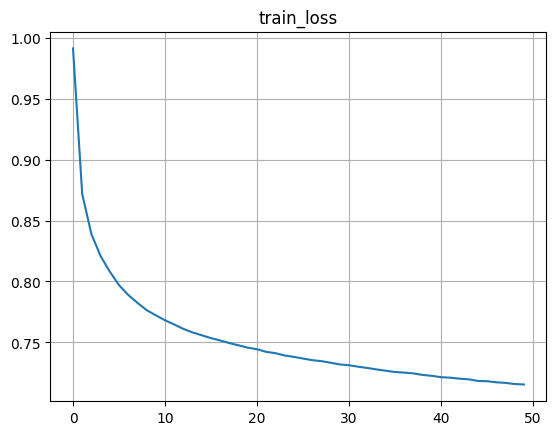

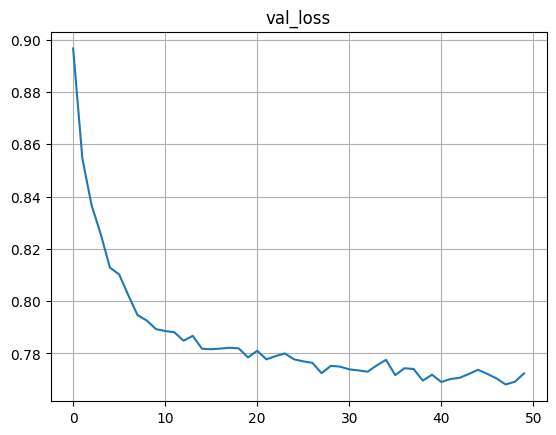

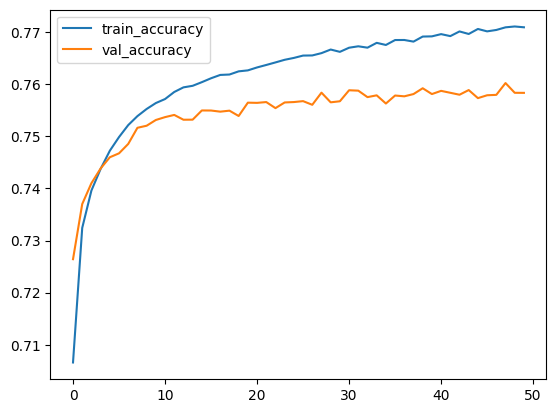

In [7]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["val_loss"] = val_loss

accuracy_data = {}
accuracy_data["train_accuracy"] = train_accuracy
accuracy_data["val_accuracy"] = val_accuracy

loss_plots(loss_data, invidual_plots=True)
accuracy_plots(accuracy_data)
